<a href="https://colab.research.google.com/github/st3vejobs/DATA-604/blob/main/final_project/DATA_604_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 604 Final Project

# Shane Hylton

### 17 July 2022

# Table of contents
1. [Abstract](#abstract)
2. [Conceptual Model](#concept)
3. [Data Exploration](#dexplore)
  1. [Arrivals Per Hour](#arr_hr)
  2. [Wait Time Per Hour](#wait_hr)
4. [Simulation Using SimPy](#simpy)
    1. [Running the Simulation](#simulate)
    2. [Visualization](#visual)
5. [Validation](#valid)
6. [Verification](#verify)
7. [Conclusion](#conclusion)
8. [Additional Simulation Attempts](#more)
  1. [Non-Simpy Simulation](#nosimp)
  2. [Failures](#fail)
  3. [SIR Model](#sir)

## Abstract<a name="abstract"></a>


### Research Question 

This simulation project was constructed after I worked with a client on developing a report for excessive wait times at fuel terminals. The client was noticing quite a few instances of vehicles being at fuel terminals for longer than expected. As a result, I created a custom report that downloads every month and shows all vehicles that were present in a fuel terminal for longer than 60 minutes. 

After using Excel to create the initial report, I wanted to see if I could simulate a day of fuel terminal visits to model the expected time spent in fuel terminals. Currently, we wait an entire month before we can see new results. If I construct a simulation, we can gain a better understanding of what takes place at the fuel terminals. 

The primary goal of this simulation will be to model the daily workflow at the fuel terminals. I will be conducting the simulation holistically.

# Conceptual Model<a name="concept"></a>

First, I will make a simpler queue model with one queue for the ten different terminals. It is more reasonable to establish one pre-queue where drivers can choose the fuel terminal with the shortest line before entering the system.

The conceptual model features a pre-queue for all terminals. After a driver selects the desired terminal, they enter the queue for that fuel pump. Once the wait time has elapsed and the pump becomes available, the driver may proceed to the pump. After the driver is finished refueling, they leave the system.

![single](https://github.com/st3vejobs/DATA-604/blob/main/final_project/single_queue.png?raw=true)

#### Package Import

In [154]:
%matplotlib inline
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *
from modsim import *
from modsim import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns


from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

np.random.seed(34)

ERROR:root:The 'ast_node_interactivity' trait of a Shell instance expected any of ['all', 'last', 'last_expr', 'none'], not the str 'last_expr_or_assign'.


In [155]:
download('https://github.com/AllenDowney/ModSimPy/blob/master/modsim/modsim.py')

try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *
from modsim import *
 

In [156]:
#!pip install https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/modsim/modsim.py

try:
    from modsim import *
except ImportError:
    !pip install modsim.py
    from modsim import *


In [157]:
def plot(*args, **options):
    """Makes line plots.
    args can be:
      plot(y)
      plot(y, style_string)
      plot(x, y)
      plot(x, y, style_string)
    options are the same as for pyplot.plot
    """
    x, y, style = parse_plot_args(*args, **options)

    if isinstance(x, pd.DataFrame) or isinstance(y, pd.DataFrame):
        raise ValueError("modsimpy.plot can't handle DataFrames.")

    if x is None:
        if isinstance(y, Quantity):
            y = y.magnitude

        if isinstance(y, (list, np.ndarray)):
            x = np.arange(len(y))

        if isinstance(y, pd.Series):
            x = y.index
            y = y.values

    x = magnitudes(x)
    y = magnitudes(y)
    underride(options, linewidth=2)

    if style is not None:
        lines = plt.plot(x, y, style, **options)
    else:
        lines = plt.plot(x, y, **options)
    return lines


def parse_plot_args(*args, **options):
    """Parse the args the same way plt.plot does."""
    x = None
    y = None
    style = None

    if len(args) == 1:
        y = args[0]
    elif len(args) == 2:
        if isinstance(args[1], str):
            y, style = args
        else:
            x, y = args
    elif len(args) == 3:
        x, y, style = args

    return x, y, style
units = pint.UnitRegistry()
Quantity = units.Quantity

def magnitudes(x):
    """Returns the magnitude of a Quantity or number, or sequence.
    x: Quantity, number, or sequence
    returns: number or list or same type as x
    """
    if isinstance(x, Quantity):
        return x.magnitude
    try:
        t = [magnitude(elt) for elt in x]

        # if x is an array, return an array
        if isinstance(x, np.ndarray):
            return np.array(t)

        # if x is a Series, return a Series of the same subtype
        if isinstance(x, pd.Series):
            return x.__class__(t, x.index)

        return t
    except TypeError:  # not iterable
        return x


def get_unit(x):
    """Returns the units of a Quantity or number.
    x: Quantity or number
    returns: Unit object or 1
    """
    return x.units if isinstance(x, Quantity) else 1



[SimPy](https://simpy.readthedocs.io/en/latest/simpy_intro/process_interaction.html) will be used to conduct the discrete event simulation.

In [158]:
!pip install simpy
import simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Exploration<a name="dexplore"></a>

### Data Source

This data is sourced from a client, and all PII has been removed from the dataset. I used Excel to clean and rename the data, and I uploaded the result to Github. 

It is important to note that the time values being presented are a decimal representation of one day. 

$$0.04 \approx 1 \  hour, 1.00 = 1 \ day.$$

All time values will be converted to integer values for the corresponding hour that the event occurs within.

In [159]:
data = pd.read_csv('https://raw.githubusercontent.com/st3vejobs/DATA-604/main/final_project/terminal_data.csv')

data.head()

data = data.rename(columns = {"Start_time_time": "time","Start_time_decimal": "decimal_time", "ExceptionDuration":"duration",
                              "Decimal_Duration":"decimal_duration","Terminal":"terminal"})
trim = data.drop(data.columns[[5]],axis = 1)

trim.head()

trim = trim.sort_values(by = 'decimal_time')
trim.head()

time_hr = 24 * trim['decimal_time']
duration_hr = 24 * trim['decimal_duration']

trim['time_hr'] = time_hr
trim['duration_hr'] = duration_hr
trim = trim.set_index(np.arange(len(trim)))
trim_long = trim
trim = trim.drop(trim[['time','decimal_time','duration','decimal_duration']],axis = 1)
trim.head()
trim_long

,time,decimal_time,duration,decimal_duration,terminal,time_hr,duration_hr
0,0:09,0.006250,1:04,0.045045,G,0.150000,1.081087
1,0:29,0.020139,1:15,0.052705,D,0.483334,1.264927
2,0:53,0.036806,1:17,0.053535,C,0.883334,1.284830
3,1:34,0.065278,1:14,0.051683,C,1.566667,1.240399
4,1:49,0.075694,1:09,0.047988,D,1.816666,1.151717
...,...,...,...,...,...,...,...
394,23:32,0.980556,1:10,0.048706,A,23.533334,1.168944
395,23:33,0.981250,1:18,0.054338,C,23.550000,1.304105
396,23:37,0.984028,1:28,0.061374,C,23.616667,1.472978
397,23:52,0.994444,1:14,0.051735,G,23.866666,1.241652


Because the vehicles enter the queue at different times, I will need to model the arrival frequency. 

### Arrivals Per Hour<a name="arr_hr"></a>

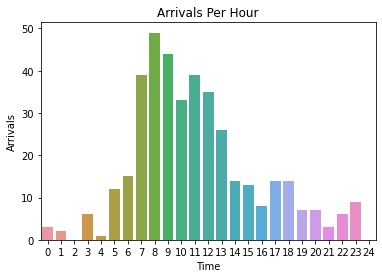

In [160]:
def pop_hour(df,hour):
  pop = df.apply(lambda df : True
                 if df['time_hr'] >= float(hour) and df['time_hr'] < float(int(hour + 1)) else False, axis = 1)
  num_rows = len(pop[pop == True].index)
  return num_rows

arrivals = pd.DataFrame(columns = ['hour', 'arrivals'])
for i in range(0,25):
  arr = pd.DataFrame([[i, pop_hour(trim,i)]], columns = ['hour','arrivals'])
  arrivals = pd.concat([arrivals,arr])

arrivals.set_index(arrivals['hour'], inplace = True)
#arrivals = arrivals.drop(arrivals[['hour']], axis = 1)
arrivals

arr = sns.barplot(x = 'hour',y = 'arrivals', data = arrivals)
arr.set(title = 'Arrivals Per Hour',xlabel = 'Time', ylabel = 'Arrivals')
arr.set_xticklabels(arr.get_xticklabels(), fontsize = 10)

plt.show()

#sns.kdeplot(data = arrivals['arrivals'])
#plt.show()

The distribution of arrivals is right-skewed. Smoothed, this resembles a Poisson distribution, with some variation.

### Wait Time Per Hour<a name="wait_hr"></a>

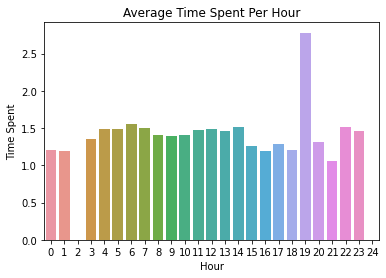

In [161]:
def wait_hourly(df,hour):
  present = df.apply(lambda df : True
                 if df['time_hr'] >= float(hour) and df['time_hr'] < float(int(hour + 1)) else False, axis = 1)
  rows = list(present[present == True].index)
  return rows
avg_wait_hourly = {}
#avg_wait_hourly = DataFrame(columns = ['Average Wait Time'], index = range(0,25))
for i in range(0,25):
  indices = wait_hourly(trim_long,i)
  total_time_hour = 0
  if len(indices) > 0:
    for j in indices:
        total_time_hour += trim_long['duration_hr'][j]
    avg_time_hr = total_time_hour / (len(indices))
  else:
    avg_time_hr = 0
  try:
      avg_wait_hourly[i] = avg_time_hr
  except KeyError:
      avg_wait_hourly[i] = avg_time_hr
  
#avg_wait_hourly['Average Wait Time'][i] = avg_time_hr

  
avg_wait_hourly = pd.DataFrame(avg_wait_hourly.items(),columns = ['hour','avg_time_spent'])
avg_wait_hourly


hourly_wait_plot = sns.barplot(x = 'hour',y = 'avg_time_spent', data = avg_wait_hourly)
hourly_wait_plot.set(title = 'Average Time Spent Per Hour',xlabel = 'Hour', ylabel = 'Time Spent')
hourly_wait_plot.set_xticklabels(arr.get_xticklabels(), fontsize = 10)

plt.show()

The distribution of wait times appears to be uniform, with two outliers. 

# Simulation of One Queue for all Terminals<a name="simpy"></a>

I will use SimPy now to produce a discrete event simulation for the ten different terminals.

In this simulation, I will use one queue, but with multiple separate lines. Drivers will be able to choose the shortest line upon arrival in the system.

For the purpose of the exercise, I will estimate that it takes 45 minutes to fuel the vehicle after the wait time has elapsed. The time given in the DataFrame is inclusive of wait time and fueling time.

In [162]:
time_frame = TimeFrame(columns = ['vehicle','time_pump_available','time_start',
                                  'time_fuel_start','time_fueling_expected','time_wait','time_exit'])


def new_arrival(environment, time_fueling_expected, terminal, vehicle):

    time_start = environment.now
    time_frame.at[vehicle, 'vehicle'] = vehicle
    time_frame.at[vehicle, 'time_start'] = time_start
    time_frame.at[vehicle, 'time_fueling_expected'] = time_fueling_expected

    with terminal.request() as req:
        
        yield req
        
        time_fueling = environment.now
        time_frame.at[vehicle, 'time_fuel_start'] = time_fueling

        time_wait = (time_fueling - time_start)
        time_frame.at[vehicle, 'time_wait'] = time_wait

        sample_fuel_duration = np.random.exponential(time_fueling_expected) #45 min to fuel
        time_frame.at[vehicle, 'fuel_duration'] = sample_fuel_duration
        
        yield environment.timeout(sample_fuel_duration)

        time_frame.at[vehicle, 'time_exit'] = environment.now

def terminal_activity(environment,avg_time_between,time_fueling_expected,terminal):

    vehicle = 0
    
    while True:
        
        arr = new_arrival(environment, time_fueling_expected, terminal, vehicle)
        environment.process(arr)
        time_between = np.random.exponential(avg_time_between)        

        yield environment.timeout(time_between)

        vehicle += 1


def run_simulation(terminals, avg_time_between, time_fueling_expected):
  environment = simpy.Environment()

  np.random.seed(34)
  terminal = simpy.Resource(environment, capacity = terminals)
  time_between = avg_time_between
  time_fueling_expected = time_fueling_expected
  
  environment.process(terminal_activity(environment, avg_time_between, time_fueling_expected, terminal))

  environment.run(until=24*60)
    
  for vehicle in range(len(time_frame)):
    if time_frame.at[vehicle,'vehicle'] == 0:
      time_frame.at[vehicle, 'time_pump_available'] = 0
    elif time_frame.at[vehicle, 'time_start'] - time_frame.at[vehicle-1, 'time_exit'] < 0:
      time_frame.at[vehicle, 'time_pump_available'] = 0
    else:
      time_frame.at[vehicle, 'time_pump_available'] = time_frame.at[vehicle, 'time_start'] - time_frame.at[vehicle-1, 'time_exit']

  return time_frame
        

### Running the Simulation<a name="simulate"></a>

In [163]:
run_simulation(10,avg_time_between,45)

,vehicle,time_pump_available,time_start,time_fuel_start,time_fueling_expected,time_wait,time_exit,fuel_duration
0,0.0,0.0,0.000000,0.000000,45.0,0.0,68.156301,68.156301
1,1.0,0.0,0.140742,0.140742,45.0,0.0,45.235290,45.094548
2,2.0,0.0,0.488924,0.488924,45.0,0.0,124.299782,123.810858
3,3.0,0.0,0.538987,0.538987,45.0,0.0,13.670250,13.131262
4,4.0,0.0,2.529337,2.529337,45.0,0.0,26.642303,24.112967
...,...,...,...,...,...,...,...,...
381,381.0,NaN,1424.816029,NaN,45.0,NaN,NaN,NaN
382,382.0,NaN,1429.113451,NaN,45.0,NaN,NaN,NaN
383,383.0,NaN,1429.554028,NaN,45.0,NaN,NaN,NaN
384,384.0,NaN,1434.421675,NaN,45.0,NaN,NaN,NaN


In [164]:
run_simulation(10,avg_time_between,35)

,vehicle,time_pump_available,time_start,time_fuel_start,time_fueling_expected,time_wait,time_exit,fuel_duration
0,0.0,0.0,0.000000,0.000000,35.0,0.0,53.010457,53.010457
1,1.0,0.0,0.140742,0.140742,35.0,0.0,35.214279,35.073537
2,2.0,0.0,0.488924,0.488924,35.0,0.0,96.786258,96.297334
3,3.0,0.0,0.538987,0.538987,35.0,0.0,10.752191,10.213204
4,4.0,0.0,2.529337,2.529337,35.0,0.0,21.283866,18.754530
...,...,...,...,...,...,...,...,...
382,382.0,0.0,1429.760803,1429.760803,35.0,0.0,NaN,13.284877
383,383.0,NaN,1429.813936,1429.813936,35.0,0.0,NaN,80.221008
384,384.0,NaN,1433.817294,1433.817294,35.0,0.0,NaN,13.002339
385,385.0,NaN,1435.017569,1435.017569,35.0,0.0,NaN,8.681270


## Visualization of Fillup Duration<a name="visual"></a>

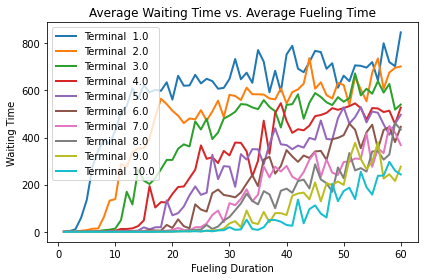

In [165]:
avg_fuel_time = linrange(1,60,1)
terminals = linrange(1,10)
avg_wait = SweepSeries()

for i in terminals:
  for j in avg_fuel_time:
    time_frame = TimeFrame(columns = ['vehicle','time_pump_available','time_start',
                                      'time_fuel_start','time_fueling_expected','time_wait','time_exit'])
    sim = run_simulation(i,avg_time_between,j)['time_wait']
    avg_wait[j] = np.mean(sim)
  label = 'Terminal  ' + str(i)
  plot(avg_wait,label = label)

decorate(xlabel = 'Fueling Duration',
         ylabel = 'Waiting Time',
         title = 'Average Waiting Time vs. Average Fueling Time')




## Model Validation<a name="valid"></a>



The model is somewhat valid, with some caveats. 
The conceptual model neglects the fact that each different fuel terminal is actually physically located in a different place from the others. The conceptual model also does not take into account other, undocumented vehicles and delays that could take place at one terminal and not another. 

The model also falls short in predicting the wait time for each terminal. The assumption at the outset was that each terminal is empty to start the day, so the wait time should near zero, and the expected fueling duration should be approximately 45 minutes. In reality, some of the vehicles in the real data waited just as long early in the day as they waited later in the day.

Where the model succeeds is that it appropriately represents the ten different terminals having ten different queues. 

The model also produced decent results. In the 45 minute fuel time simulation, the model yielded 325 fillups completed when compared to approximately 384 fillups completed before midnight in the real world system.
In the 35 minute fuel time simulation, the model yielded 381 completed fillups compared to the 384 produced by the real world data. 


## Model Verification<a name="verify"></a>



The conceptual model I constructed was to have one large fueling station with ten separate fuel terminals. In the simulation, I implemented the conceptual model to include ten separate queues for ten separate fuel pumps, all in the same place. 

The model is verified to meet the conceptual specifications.

# Conclusion<a name="conclusion"></a>

Overall, this simulation did a fair job of representing the process of a fleet of vehicles arriving at fuel terminals at different times. 

It is not necessarily accurate in the real world sense, because the fuel terminals I sampled are not all in the same location (for the purpose of the exercise, I have imagined that they are all in the same location). 

The simulation provides a reasonable view of what any given day could be like, and the results of the simulation are somewhat close to reality. 

This simulation does not capture the full picture of the problem at hand, but it does a reasonable job at managing with what limited data I could provide.

The other issue with the simulation is that in reality, the distribution of wait times is uniform across the day, while the vehicle arrivals follow a Poisson distribution. As a future step, I would like to try to implement a tiered simulation, where the number of available terminals changes throughtout the day. With that being said, that still would not resolve the bottleneck at the end of the day, because the fuel station was operating at full capacity for the entire time frame.

I made several other attempts while I was working to understand the simulation and simPy itself, and I have included the other attempts below.

# Additional Attempts<a name="more"></a>


## Non-Simpy Simulation of One Queue<a name="nosimp"></a>

In this simulation practice, I will be using one queue, with one pump that is ten times faster than one pump alone. This is an implementation of previous techniques we learned.

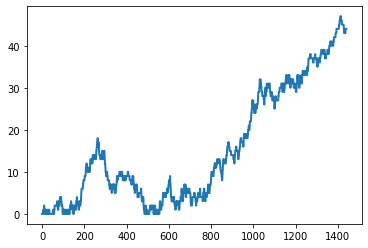

In [166]:
def create_system(lam,mu):
  return System(lam = lam, mu = mu, duration = 24 * 60) ## duration in minutes

mu = 10 / 60 * np.mean(trim_long['duration_hr']) # fuel rate per minute (10 Fuel Terminals)
lam = (np.mean(arrivals['arrivals'])/60) # arrivals per minute
system = create_system(lam,mu)
system

def update_func(waiting,t,system):
  if waiting > 0:
    if flip(system.mu):
      waiting -= 1
  if flip(system.lam):
    waiting += 1
  return waiting

def run_simulation(system,update_func):
  waiting = 0
  result = TimeSeries()
  result[0] = waiting

  for t in linrange(0,system.duration):
    waiting = update_func(waiting,t,system)
    result[t + 1] = waiting
  return result

result = run_simulation(system,update_func)
plot(result)


def compute_littles_law(result,system):
  L = result.mean()
  W = L / system.lam
  return L, W

#compute_littles_law(result,system)

Similar to attempting to get gasoline at Costco, the line just gets longer and longer. 

In [167]:
def sweep_lam(lam_array, mu, update_func):
  sweep = SweepSeries()

  for lam in lam_array:
    system = create_system(lam,mu)
    result = run_simulation(system,update_func)
    L,W = compute_littles_law(result, system)
    sweep[lam] = W
  return sweep

lam_array = linspace(0.1 * mu, 0.8 * mu, 101)

sweep = sweep_lam(lam_array, mu, update_func)


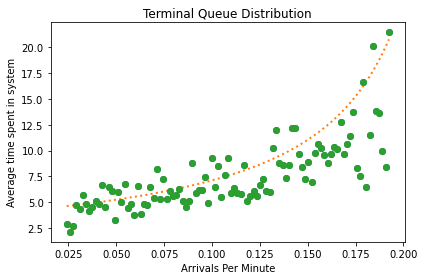

In [168]:
plot(sweep, 'o')
decorate(xlabel = 'Late Arrivals Per Minute',
         ylabel = 'Average time spent in system',
         title = 'Terminal Queue Distribution')
def plot_W(lam_array,mu):
  W = 1 / (mu - lam_array)
  plot(lam_array, W, ':')
plot_W(lam_array,mu)
plot(sweep,'o')
decorate(xlabel = 'Arrivals Per Minute',
         ylabel = 'Average time spent in system',
         title = 'Terminal Queue Distribution')

Next, I will incorporate the different terminals, with a single queue.

In [169]:
time_between = pd.DataFrame(columns = ['time_between'],index = trim_long.index)
for i in range(len(trim_long)):
  if i == 0:
    time_between['time_between'][i] = 0
  elif i > 0:
    diff = trim_long['time_hr'][i] - trim_long['time_hr'][i - 1]
    time_between['time_between'][i] = diff
                    
time_between

,time_between
0,0
1,0.333334
2,0.400001
3,0.683333
4,0.249998
...,...
394,0.083335
395,0.016666
396,0.066667
397,0.249998


In [170]:
trim_long['time_between'] = time_between['time_between']


In [171]:
dur_min = pd.DataFrame(columns = ['duration_min'],index = trim_long.index)
time_bet_min = pd.DataFrame(columns = ['time_between_min'],index = trim_long.index)

for i in range(len(trim_long)):
  dur_min['duration_min'][i] = 60*trim_long['duration_hr'][i]
  time_bet_min['time_between_min'][i] = 60*trim_long['time_between'][i]

trim_long['time_between_min'] = time_bet_min['time_between_min']
trim_long['duration_min'] = dur_min['duration_min']
trim_long.head()

,time,decimal_time,duration,decimal_duration,terminal,time_hr,duration_hr,time_between,time_between_min,duration_min
0,0:09,0.006250,1:04,0.045045,G,0.150000,1.081087,0,0,64.865232
1,0:29,0.020139,1:15,0.052705,D,0.483334,1.264927,0.333334,20.000016,75.895632
2,0:53,0.036806,1:17,0.053535,C,0.883334,1.284830,0.400001,24.000048,77.089824
3,1:34,0.065278,1:14,0.051683,C,1.566667,1.240399,0.683333,40.999968,74.423952
4,1:49,0.075694,1:09,0.047988,D,1.816666,1.151717,0.249998,14.999904,69.103008


In [172]:
def create_system(lam,mu):
  return System(lam = lam, mu=mu,duration = 24*60)

In [173]:
#lam = len(trim_long) / (24*60) #total daily arrivals divided by minutes per day = arr/min

avg_time_between = np.mean(trim_long['time_between_min'])

avg_wait_time = np.mean(trim_long['duration_min'])

lam = 1/avg_time_between
mu = 1/avg_wait_time

#lam = avg_time_between
#mu = avg_wait_time


system = create_system(lam,mu)
system

System(duration=1440, lam=0.279411755313891, mu=0.011549028457310461)

## One Queue, Any Terminal<a name="fail"></a>

I attempted a few different ideas here, and they were unsuccessful, but I will keep the code.

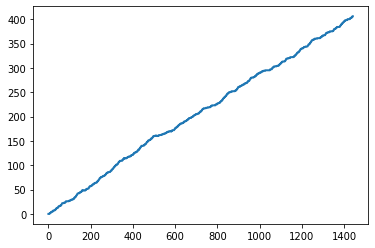

In [174]:
def update_func(waiting,t,system):
  if waiting > 0:
    if flip(system.mu):
      waiting -= 1
  if flip(system.lam):
    waiting += 1
  return waiting

def run_simulation(system,update_func):
  waiting = 0
  result = TimeSeries()
  result[0] = waiting

  for t in linrange(0,system.duration):
    waiting = update_func(waiting,t,system)
    result[t + 1] = waiting
  return result


result = run_simulation(system,update_func)
plot(result)



One Queue for Ten Terminals

### Ten Queues for Ten Terminals

I will keep the code here for potential future use, but this attempt did not work, and I could not quite understand why.

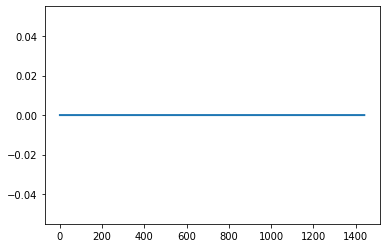

In [175]:
a,b,c,d,e,f,g,h,i,j = 0,0,0,0,0,0,0,0,0,0
def update_func(a,b,c,d,e,f,g,h,i,j,t,system):
  queues = {}
  best_terminal = 'a'
  if a > 0 and flip(system.mu):
    a -= 1
    try:
      queues['a'] = a
    except KeyError:
      queues['a'] = a
  if b > 0 and flip(system.mu):
    b -= 1
    try:
      queues['b'] = b
    except KeyError:
      queues['b'] = b
  if c > 0 and flip(system.mu):
    c -= 1      
    try:
      queues['c'] = c
    except KeyError:
      queues['c'] = c
  if d > 0 and flip(system.mu):
    d -= 1   
    try:
      queues['d'] = d
    except KeyError:
      queues['d'] = d
  if e > 0 and flip(system.mu):
    e -= 1
    try:
      queues['e'] = e
    except KeyError:
      queues['e'] = e
  if f > 0 and flip(system.mu):
    f -= 1
    try:
      queues['f'] = f
    except KeyError:
      queues['f'] = f
  if g > 0 and flip(system.mu):
    g -= 1
    try:
      queues['g'] = g
    except KeyError:
      queues['g'] = g
  if h > 0 and flip(system.mu):
    h -= 1
    try:
      queues['h'] = h
    except KeyError:
      queues['h'] = h
  if i > 0 and flip(system.mu):
    i -= 1
    try:
      queues['i'] = i
    except KeyError:
      queues['i'] = i
  if j > 0 and flip(system.mu):
    j -= 1
    try:
      queues['j'] = j
    except KeyError:
      queues['j'] = j

  if flip(system.lam):
      shortest_line = min([a,b,c,d,e,f,g,h,i,j])
      for i in queues:
        if queues[i] <= shortest_line:
          shortest_line = queues[i]
          best_terminal = i
        if best_terminal == 'a':
          a +=1
        elif best_terminal == 'b':
          b +=1       
        elif best_terminal == 'c':
          c +=1 
        elif best_terminal == 'd':
          d +=1 
        elif best_terminal == 'e':
          e +=1 
        elif best_terminal == 'f':
          f +=1 
        elif best_terminal == 'g':
          g +=1 
        elif best_terminal == 'h':
          h +=1 
        elif best_terminal == 'i':
          i +=1 
        else:
          j +=1 
  return a,b,c,d,e,f,g,h,i,j


def run_simulation(system,update_func):
  a,b,c,d,e,f,g,h,i,j = 0,0,0,0,0,0,0,0,0,0
  results = TimeSeries()
  results[0] = a + b + c + d + e + f + g + h + i + j

  for t in linrange(0,system.duration):
    a,b,c,d,e,f,g,h,i,j = update_func(a,b,c,d,e,f,g,h,i,j,t,system)
    results[t + 1] = a + b + c + d + e + f + g + h + i + j
  return results

result = run_simulation(system,update_func)
plot(result)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


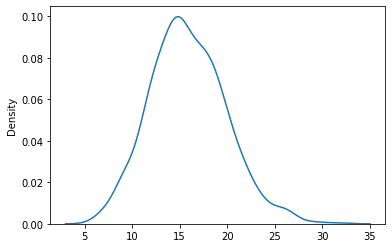

In [176]:
drive_time = np.random.exponential(30,60)
drive_time

from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(random.poisson(np.mean(arrivals['arrivals']),size=1000), hist=False)

plt.show()


## Curiosity: Can the SIR Model be implemented?<a name="sir"></a>

Similar the SIR model, I will construct a DWF (Driving, Waiting, Fueled) model. 

A very important assumption must be made, and that is, how long is a driver expected to be driving before entering the queue to fill the vehicle? 

If we assume that all drivers begin driving at midnight, then the expected driving duration would be twelve hours. If we assume that the first thing a driver does to begin the day is visit the fuel terminal, then we have two options. Either each driver begins by default in a queue (this will cause the beta to be undefined), or each driver will need to drive from a different location to reach the queue. 

For the purpose of the simulation, I will assume that drivers need to travel an average of 30 minutes to reach the fuel terminal, and the time listed in the dataframe represents their time of departure. I will assume a pseudo-random distribution of travel time to the fuel terminal. The distribution will span from 0 to 60 minutes, and it will be modeled with an exponential distribution. I chose the exponential distribution because it will provide a better fit for elapsed time for a single arrival, while Poisson will provide the rate of arrivals. 


In [177]:
trim_long

,time,decimal_time,duration,decimal_duration,terminal,time_hr,duration_hr,time_between,time_between_min,duration_min
0,0:09,0.006250,1:04,0.045045,G,0.150000,1.081087,0,0,64.865232
1,0:29,0.020139,1:15,0.052705,D,0.483334,1.264927,0.333334,20.000016,75.895632
2,0:53,0.036806,1:17,0.053535,C,0.883334,1.284830,0.400001,24.000048,77.089824
3,1:34,0.065278,1:14,0.051683,C,1.566667,1.240399,0.683333,40.999968,74.423952
4,1:49,0.075694,1:09,0.047988,D,1.816666,1.151717,0.249998,14.999904,69.103008
...,...,...,...,...,...,...,...,...,...,...
394,23:32,0.980556,1:10,0.048706,A,23.533334,1.168944,0.083335,5.000112,70.13664
395,23:33,0.981250,1:18,0.054338,C,23.550000,1.304105,0.016666,0.999936,78.246288
396,23:37,0.984028,1:28,0.061374,C,23.616667,1.472978,0.066667,4.000032,88.378704
397,23:52,0.994444,1:14,0.051735,G,23.866666,1.241652,0.249998,14.999904,74.49912


In [178]:
t_0 = 0
t_end = 24*60
elapsed_time = t_end - t_0

drive_time = np.random.exponential(30,len(trim_long))
trim_long['drive_time'] = drive_time

def pop_hour(df,hour):
  pop = df.apply(lambda df : True
                 if df['time_hr'] >= float(hour) and df['time_hr'] < float(int(hour + 1)) else False, axis = 1)
  num_rows = len(pop[pop == True].index)
  return num_rows

#pop_hour(trim,float(0))
p_0 = pop_hour(trim,float(0))/60 # in minutes

init = State(D = len(trim_long),W = p_0, F = 0) #Assume All vehicles are being driven (This is a potential problem)
init /= sum(init)

d_w = np.mean(trim_long['drive_time']*60) #expected time between driving and waiting in minutes (hours are in decimal form) 
w_f = np.mean(trim_long['duration_hr']*60) #expected time between waiting and being refueled in minutes

beta = 1/ avg_time_between
gamma = 1/ w_f

def create_system(beta,gamma):
  init = State(D = len(trim_long),W  = p_0, F = 0)
  init /= sum(init)
  t_0 = 0
  t_end = 24*60
  return System(init = init, t_0 = t_0, t_end = t_end, beta = beta, gamma = gamma)

p_end = pop_hour(trim,float(24))/60

def update_func(state, t, system):
  d,w,f = state

  waiting = system.beta * d * w
  fueled = system.gamma * w

  d -= waiting
  w += (waiting - fueled)
  f += fueled

  return State(D=d, W=w, F=f) 


system = create_system(beta,gamma)
state = update_func(init,0,system)
state

def run_simulation(system, update_func):
  frame = TimeFrame(columns = system.init.index)
  frame.loc[system.t_0] = system.init
  for t in linrange(system.t_0, system.t_end):
    frame.loc[t + 1] = update_func(frame.loc[t],t,system)
  return frame

system = create_system(beta,gamma)
result = run_simulation(system,update_func)
result


,D,W,F
0.0,9.998747e-01,1.252976e-04,0.000000
1.0,9.998397e-01,1.588557e-04,0.000001
2.0,9.997953e-01,2.014002e-04,0.000003
3.0,9.997391e-01,2.553362e-04,0.000006
4.0,9.996677e-01,3.237127e-04,0.000009
...,...,...,...
1437.0,5.329074e-12,8.719371e-08,1.000000
1438.0,5.329074e-12,8.618671e-08,1.000000
1439.0,5.329074e-12,8.519133e-08,1.000000
1440.0,5.329074e-12,8.420746e-08,1.000000


### Updating the DWF Model

If we update the DWF model to be more realistic, the time between driving and arriving will need to be updated. In the previous representation, the arrivals at the terminal were modeled similar to disease spread, but realistically, no vehicle arriving at the terminal should be expected to impact another. 

I will use the average number of vehicles arriving in the day, and assume that it is uniformly distributed. 


### Plot of DWF Model

If all Drivers began heading toward the fuel terminal at the start of the day, the process of fueling all 398 vehicles would be complete rather quickly, with almost no more vehicles left to fuel by 10 AM. 

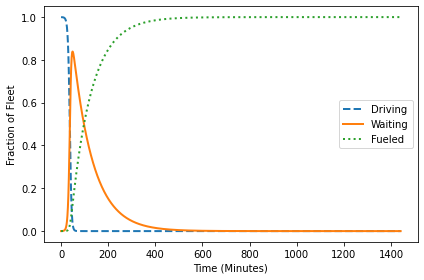

In [179]:
def plot_results(D,W,F):
  plot(D, '--', label='Driving')
  plot(W, '-', label='Waiting')
  plot(F, ':', label='Fueled')
  decorate(xlabel='Time (Minutes)',
           ylabel='Fraction of Fleet')

plot_results(result.D,result.W,result.F)   

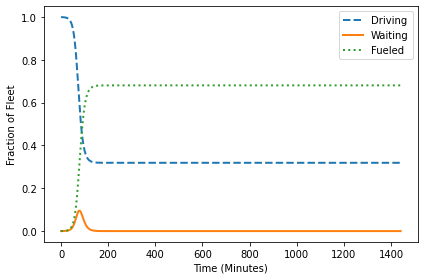

In [180]:
arrivals_per_hour = len(trim_long)/24
time_between_arrivals = 60/arrivals_per_hour #if uniform
fillups_per_hour = 10 #Assuming Each Pump can fill one vehicle per hour
time_between_fillups = 60/fillups_per_hour # if uniform
beta = 1/time_between_arrivals
gamma = 1/time_between_fillups


system = create_system(beta,gamma)
result = run_simulation(system,update_func)
result = run_simulation(system,update_func)

plot_results(result.D,result.W,result.F)   

#### Takeaways from SIR Model Curiosity

The SIR model is not a good way to perform discrete event simulation.